In [1]:
# Imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.rcParams.update({'font.size': 12,
                 'axes.spines.right': False,
                 'axes.spines.top': False,
                 'axes.linewidth':1.2,
                 'xtick.major.size': 6,
                 'xtick.major.width': 1.2,
                 'ytick.major.size': 6,
                 'ytick.major.width': 1.2,
                 'legend.frameon': False,
                 'legend.handletextpad': 0.1,
                 'figure.figsize': [10.0, 3.0],
                 'svg.fonttype': 'none',
                 'text.usetex': False})

In [2]:
# Load data 

Isteps_data = pd.read_excel('VO2_data_currents.xlsx',header=0)

# Extract relevant variables 
data_time = np.array(Isteps_data['Time'][2:])
Isteps = np.array(Isteps_data.iloc[1][1::4])
voltage_traces = np.array(Isteps_data.iloc[2:,1::4]).T
resistance_traces = np.array(Isteps_data.iloc[2:,2::4]).T
current_traces = np.array(Isteps_data.iloc[2:,3::4]).T

tau = np.zeros(len(Isteps))
for i,R in enumerate(resistance_traces):
    tau_R = (1-np.exp(-1)) * (R[-1]-R[0]) # value of R at the tau timepoint
    tau[i] = data_time[np.where(R>tau_R)[0][0]] # in seconds


# <font color='blue'> 1. Emulating VO2 properties </font>


In [180]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt, timescale=70, insulatorR=5600, metalR=220):
        self.dt = dt
        self.insulatorR = insulatorR
        self.metalR = metalR
        self.R = self.insulatorR + self.metalR
        self.R_history = []
        self.controlI = 0
        self.controlI_history = []
        self.timescale = timescale
        self.peak_R = self.R
        
    def time_step(self):
        self.R_history.append(self.R)
        self.controlI_history.append(self.controlI)

        R_eq = self.transfer_func(self.controlI)         

        if self.R > R_eq:
            self.peak_R = R_eq
            rise_tau = np.maximum(self.dt, self.rise_tau(R=self.R, timescale=self.timescale))
            dRdt = (R_eq - self.R) / rise_tau
        else:
            decay_tau = np.maximum(self.dt, self.decay_tau(R=self.peak_R, timescale=self.timescale))    
            dRdt = (R_eq - self.R)**0.95 / decay_tau
            
        self.R += dRdt * self.dt
        
    def transfer_func(self, controlI):
        '''
        Function to convert between controlI and resistance
        controlI: current in units of mA
        '''        
        R_eq = self.insulatorR*np.exp(-0.12*controlI)+self.metalR # (Ohm)
        g_eq  = 1 / R_eq * 1e9 # convert to conductance (nS)
        return R_eq
    
    def inv_transfer_func(self, R):
        controlI = np.log((R-self.metalR)/self.insulatorR)/(-0.12)
        return controlI
        
    def decay_tau(self, controlI=None, R=None, timescale=70):
        if controlI is None:
            controlI = self.inv_transfer_func(R)
        tau = (0.02 * controlI**1.05) * np.exp(0.2*(timescale-70))
        tau = tau * 1e3 # convert to ms
        return tau 
    
    def rise_tau(self, R=None, timescale=70):
        tau = 1/(R+200) * np.exp(0.2*(timescale-72))
        tau = tau * 1e3 # convert to ms
        return tau
    
    @property
    def g(self):
        # Convert from resistance (Ohm) to conductance (nS)
        return 1e9/self.R
    

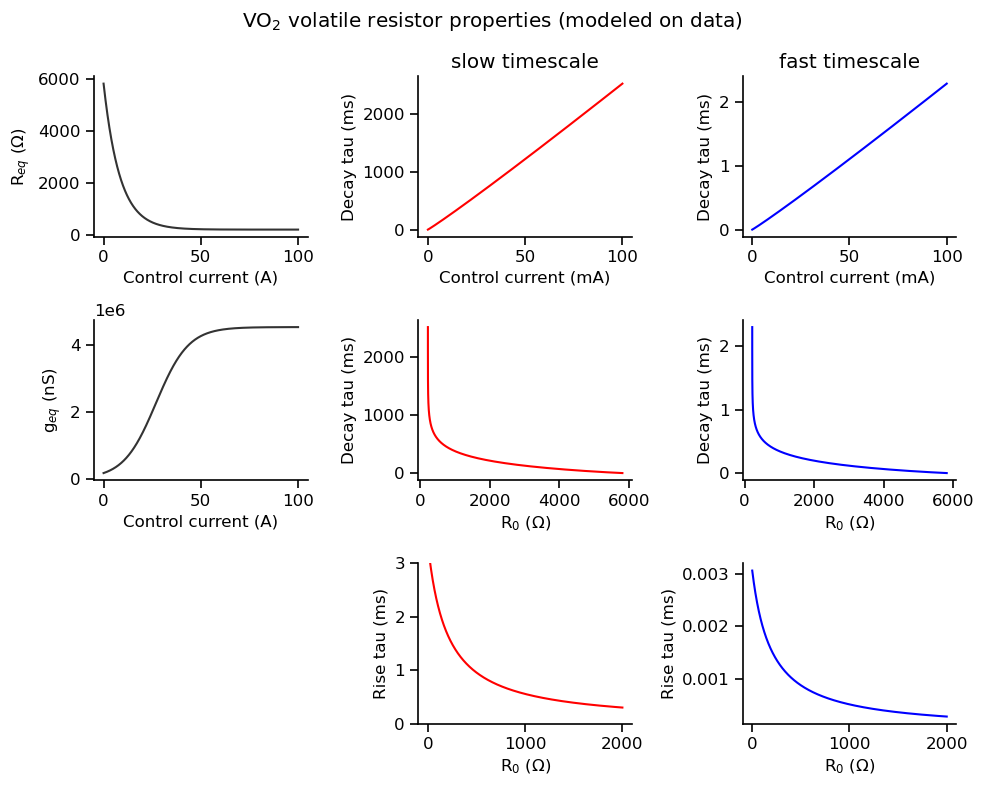

In [181]:
# Plot properties 

def VO2_test_pulse(dt, T, stim_time, timescale):
    '''
    Simulate a test pulse of a VO2 volatile resistor
    :param dt: time step (ms)
    :param T: simulation time (ms)
    '''

    time = np.arange(0., T, dt)

    R_hist_ls = []
    controlI_hist_ls = []
    for pulseI in np.arange(20,110,10):
        g_volatile = Volatile_Resistor(dt, timescale=timescale)
        for t in time:
            if t>stim_time[0] and t<stim_time[1]:
                g_volatile.controlI = pulseI  
            else:
                g_volatile.controlI = 0
            g_volatile.time_step()
        R_hist_ls.append(g_volatile.R_history)
        controlI_hist_ls.append(g_volatile.controlI_history)

    R_hist = np.array(R_hist_ls).T
    controlI_hist = np.array(controlI_hist_ls).T
    return time, R_hist, controlI_hist

# Simulation runtime parameters
dt = 0.1  # time step (ms)
T = 300   # simulation time (ms)
time = np.arange(0., T, dt)

line_color = [0.2,0.2,0.2]
fig,ax = plt.subplots(3,3,figsize=[10,8])
g_volatile = Volatile_Resistor(dt)
controlI = np.linspace(0,100,1000)
R_eq = g_volatile.transfer_func(controlI)
g_eq = 1e9 / R_eq

ax[0,0].plot(controlI,R_eq, c=line_color)
ax[0,0].set_xlabel('Control current (A)')
ax[0,0].set_ylabel('R$_{eq}$ (Ω)')

ax[1,0].plot(controlI,g_eq, c=line_color)
ax[1,0].set_xlabel('Control current (A)')
ax[1,0].set_ylabel('g$_{eq}$ (nS)')

ax[0,1].plot(controlI,g_volatile.decay_tau(controlI=controlI,timescale=70),c='r',label='70°C')
ax[0,1].set_title('slow timescale')
ax[0,1].set_xlabel('Control current (mA)')
ax[0,1].set_ylabel('Decay tau (ms)')

ax[0,2].plot(controlI,g_volatile.decay_tau(controlI=controlI,timescale=35),c='b',label='30°C')
ax[0,2].set_title('fast timescale')
ax[0,2].set_xlabel('Control current (mA)')
ax[0,2].set_ylabel('Decay tau (ms)')

ax[1,1].plot(R_eq,g_volatile.decay_tau(R=R_eq,timescale=70),c='r')
ax[1,1].set_xlabel('R$_{0}$ (Ω)')
ax[1,1].set_ylabel('Decay tau (ms)')

ax[1,2].plot(R_eq,g_volatile.decay_tau(R=R_eq,timescale=35),c='b')
ax[1,2].set_xlabel('R$_{0}$ (Ω)')
ax[1,2].set_ylabel('Decay tau (ms)')

ax[2,0].axis('off')
R_range = np.linspace(0,2000,1000)
ax[2,1].plot(R_range,g_volatile.rise_tau(R=R_range,timescale=70),c='r')
ax[2,1].set_xlabel('R$_{0}$ (Ω)')
ax[2,1].set_ylabel('Rise tau (ms)')
ax[2,1].set_ylim([0,3])

R_range = np.linspace(0,2000,1000)
ax[2,2].plot(R_range,g_volatile.rise_tau(R=R_range,timescale=35),c='b')
ax[2,2].set_xlabel('R$_{0}$ (Ω)')
ax[2,2].set_ylabel('Rise tau (ms)')

plt.suptitle('VO$_{2}$ volatile resistor properties (modeled on data)')
plt.tight_layout()
plt.show()

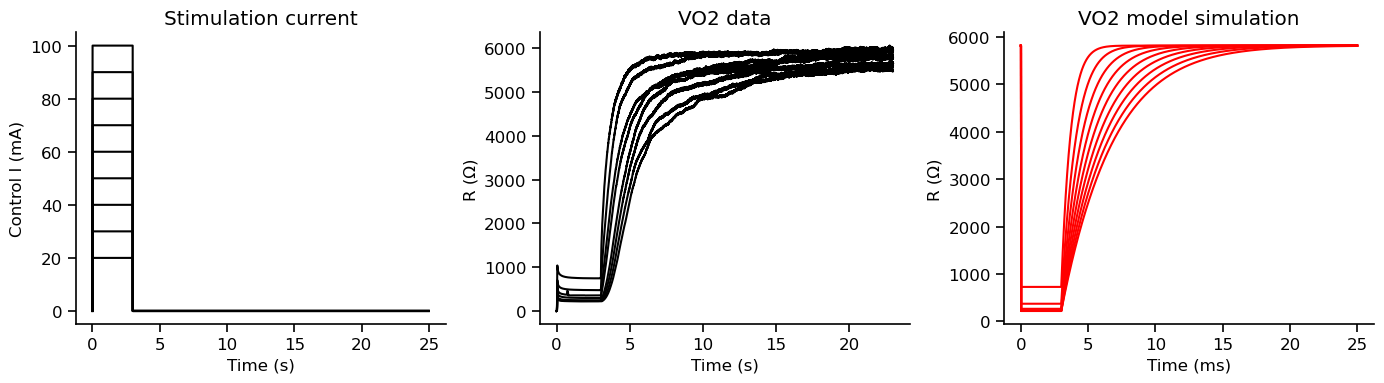

In [182]:
# Plot data vs simulation 

fig,ax = plt.subplots(1,3,figsize=[14,4])

plot_nr = (1)
for i,R in enumerate(resistance_traces):
    ax[plot_nr].plot(data_time, R, label=Isteps[i], c='k')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_ylabel('R (Ω)')
# ax[plot_nr].set_xlim([1.,1.05])
# ax[plot_nr].set_ylim(top=5000)
ax[plot_nr].set_title('VO2 data')

# plot_nr = (1,0)
# for i,I in enumerate(current_traces):
#     ax[plot_nr].plot(data_time, I*1000, label=Isteps[i], c='k')
# ax[plot_nr].set_xlabel('Time (s)')
# ax[plot_nr].set_ylabel('Control I (mA)')
# # ax[0,1].legend()

sim_time, R_hist, controlI_hist = VO2_test_pulse(dt=10,T=25000, stim_time=(0,3000), timescale=70)
sim_time /= 1000
plot_nr = (2)
ax[plot_nr].plot(sim_time, R_hist, c='r')
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel('R (Ω)')
ax[plot_nr].set_title('VO2 model simulation')

plot_nr = 0
ax[plot_nr].plot(sim_time, controlI_hist, 'k')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_ylabel('Control I (mA)')
ax[plot_nr].set_title('Stimulation current')
plt.tight_layout()
plt.show()

fig.savefig('figures/Rrelaxation.png',dpi=300)
fig.savefig('figures/Rrelaxation.svg',dpi=300)

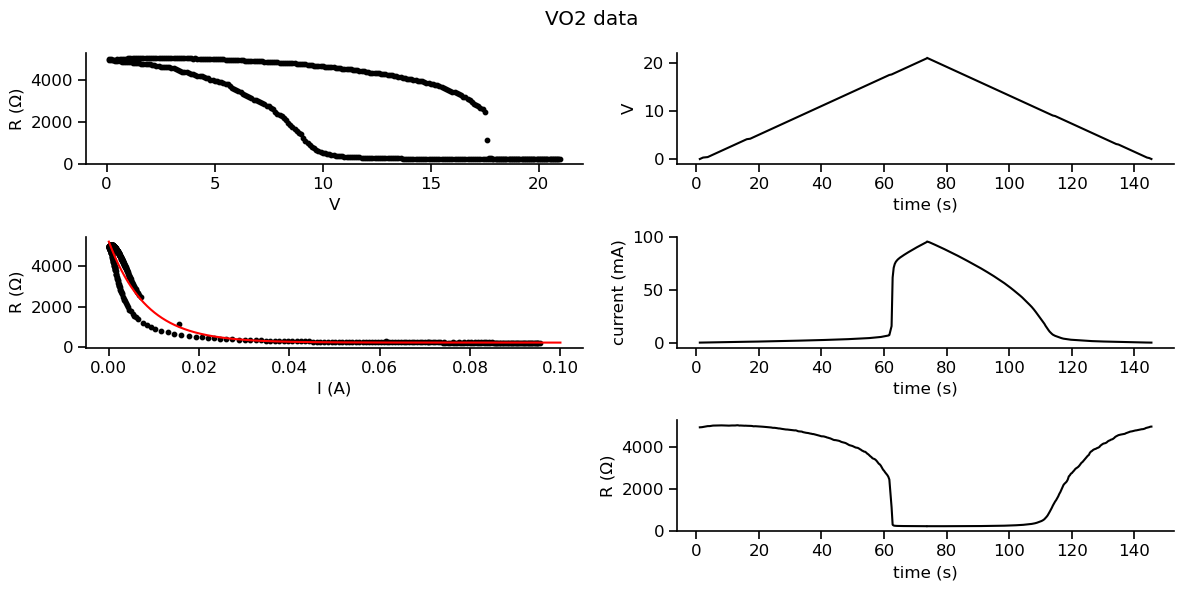

In [183]:
# Plot voltage ramp data 

RV_data = pd.read_csv('VO2_data_RvsV_transition.csv',header=34)

# Extract relevant variables 
time = RV_data['SMU-1 Time (s)']
V = RV_data['SMU-1 Voltage (V)']
I = RV_data['SMU-1 Current (A)']
R = RV_data['SMU-1 Resistance (Ω)']

# Generate plots
fig,ax = plt.subplots(3,2,figsize=[12,6])

ax[0,0].scatter(V[209:],R[209:],s=10, c='k')
ax[0,0].scatter(V[:209],R[:209],s=10, c='k')
ax[0,0].set_xlabel('V')
ax[0,0].set_ylabel('R (Ω)')

ax[1,0].scatter(I[209:],R[209:],s=10, c='k')
ax[1,0].scatter(I[:209],R[:209],s=10, c='k')
ax[1,0].set_xlabel('I (A)')
ax[1,0].set_ylabel('R (Ω)')

x = np.linspace(0,100,1000)
y = lambda x: 5000*np.exp(-0.12*x)+220
ax[1,0].plot(x/1000,y(x), 'r')

ax[0,1].plot(time[209:], V[209:], c='k')
ax[0,1].plot(time[:209], V[:209], c='k')
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('V')

ax[1,1].plot(time[209:], I[209:]*1000, c='k')
ax[1,1].plot(time[:209], I[:209]*1000, c='k')
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_ylabel('current (mA)')

ax[2,1].plot(time[209:], R[209:], c='k')
ax[2,1].plot(time[:209], R[:209], c='k')
ax[2,1].set_xlabel('time (s)')
ax[2,1].set_ylabel('R (Ω)')

fig.suptitle('VO2 data')

ax[2,0].axis('off')
plt.tight_layout()
plt.show()

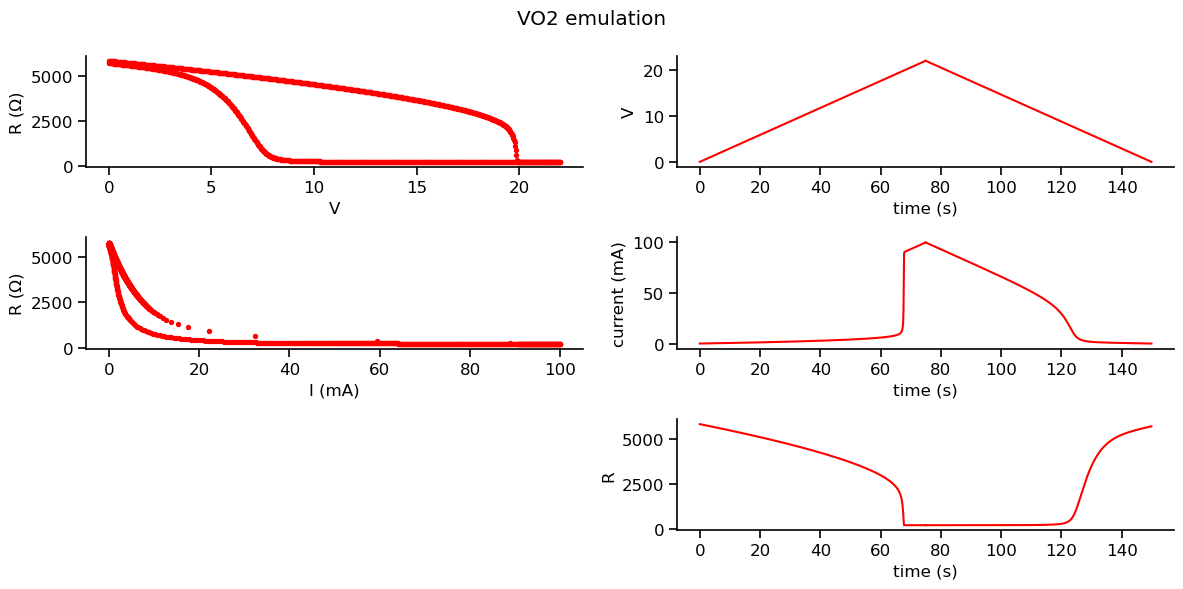

In [184]:
# Plot voltage ramp (simulation) 

dt = 100 #ms
T = 150000 #ms
time = np.arange(0,T,dt)

v1 = np.linspace(0,22,len(time)//2)
v2 = np.flip(v1)
V = np.concatenate([v1,v2])

g_volatile = Volatile_Resistor(dt,timescale=70)

for t in range(len(time)):
    g_volatile.controlI = V[t] / g_volatile.R * 1000
    g_volatile.time_step()
    
time = time/1000

fig, ax = plt.subplots(3,2,figsize=[12,6])

ax[0,0].scatter(V[:len(v1)],g_volatile.R_history[:len(v1)],s=8, c='r')
ax[0,0].scatter(V[len(v1):],g_volatile.R_history[len(v1):],s=8, c='r')
ax[0,0].set_xlabel('V')
ax[0,0].set_ylabel('R (Ω)')

ax[1,0].scatter(g_volatile.controlI_history[:len(v1)],g_volatile.R_history[:len(v1)],s=8, c='r')
ax[1,0].scatter(g_volatile.controlI_history[len(v1):],g_volatile.R_history[len(v1):],s=8, c='r')
ax[1,0].set_xlabel('I (mA)')
ax[1,0].set_ylabel('R (Ω)')

ax[2,0].axis('off')

ax[0,1].plot(time[:len(v1)],V[:len(v1)], c='r')
ax[0,1].plot(time[len(v1):],V[len(v1):], c='r')
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('V')

ax[1,1].plot(time[:len(v1)],g_volatile.controlI_history[:len(v1)], c='r')
ax[1,1].plot(time[len(v1):],g_volatile.controlI_history[len(v1):], c='r')
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_ylabel('current (mA)')

ax[2,1].plot(time[:len(v1)],g_volatile.R_history[:len(v1)], c='r')
ax[2,1].plot(time[len(v1):],g_volatile.R_history[len(v1):], c='r')
ax[2,1].set_xlabel('time (s)')
ax[2,1].set_ylabel('R')

fig.suptitle('VO2 emulation')

plt.tight_layout()
plt.show()

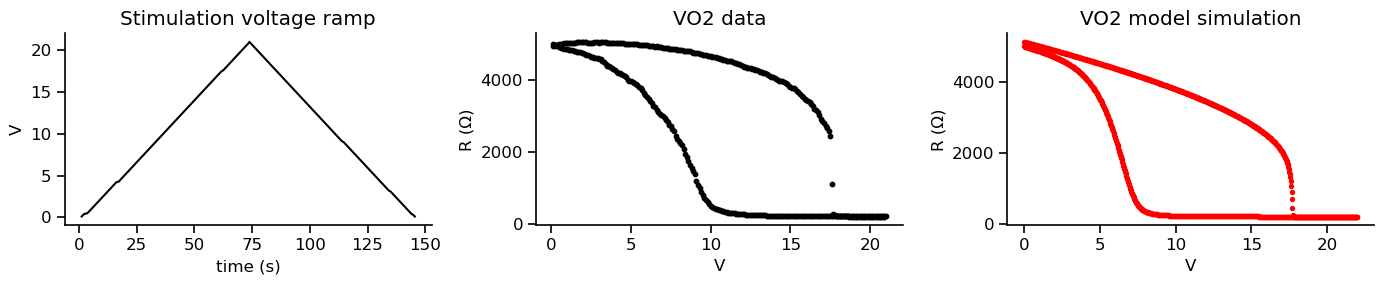

In [185]:
# Generate plots 
fig,ax = plt.subplots(1,3,figsize=[14,3])

time = RV_data['SMU-1 Time (s)']
V = RV_data['SMU-1 Voltage (V)']
I = RV_data['SMU-1 Current (A)']
R = RV_data['SMU-1 Resistance (Ω)']

plot_nr = (0)
ax[plot_nr].plot(time[209:], V[209:], c='k')
ax[plot_nr].plot(time[:209], V[:209], c='k')
ax[plot_nr].set_xlabel('time (s)')
ax[plot_nr].set_ylabel('V')
ax[plot_nr].set_title('Stimulation voltage ramp')

plot_nr = (1)
ax[plot_nr].scatter(V[209:],R[209:],s=10, c='k')
ax[plot_nr].scatter(V[:209],R[:209],s=10, c='k')
ax[plot_nr].set_xlabel('V')
ax[plot_nr].set_ylabel('R (Ω)')
ax[plot_nr].set_title('VO2 data')

time = np.arange(0,T,dt)
v1 = np.linspace(0,22,len(time)//2)
v2 = np.flip(v1)
V = np.concatenate([v1,v2])

g_volatile = Volatile_Resistor(dt,timescale=70,insulatorR=4900)

for t in range(len(time)):
    g_volatile.controlI = V[t] / g_volatile.R * 1000
    g_volatile.time_step()
time = time/1000

plot_nr = 2
ax[plot_nr].scatter(V[:len(v1)],g_volatile.R_history[:len(v1)],s=8, c='r')
ax[plot_nr].scatter(V[len(v1):],g_volatile.R_history[len(v1):],s=8, c='r')
ax[plot_nr].set_xlabel('V')
ax[plot_nr].set_ylabel('R (Ω)')
ax[plot_nr].set_title('VO2 model simulation')

plt.tight_layout()

fig.savefig('figures/RV_hysteresis.png', dpi=300)
fig.savefig('figures/RV_hysteresis.svg', dpi=300)

# <font color='blue'> 2. Simulating AMPA/NMDA conductance-based synapses with neuromorphic hardware </font>


<img src="images/Neuromorphic_circuit_diagram8.png" width="350">

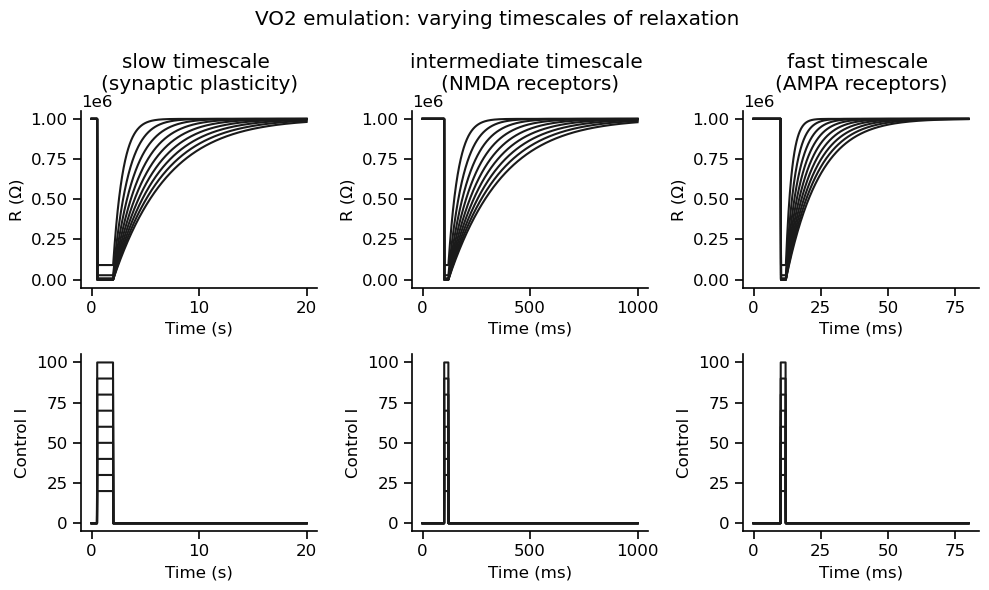

In [186]:
# Plot test pulses: replicating experiments 

def VO2_test_pulse(dt, T, stim_time, timescale):
    '''
    Simulate a test pulse of a VO2 volatile resistor
    :param dt: time step (ms)
    :param T: simulation time (ms)
    '''

    time = np.arange(0., T, dt)

    R_hist_ls = []
    controlI_hist_ls = []
    for pulseI in np.arange(20,110,10):
        g_volatile = Volatile_Resistor(dt, timescale=timescale, insulatorR=1e6, metalR=1e2)
        for t in time:
            if t>stim_time[0] and t<stim_time[1]:
                g_volatile.controlI = pulseI  
            else:
                g_volatile.controlI = 0
            g_volatile.time_step()
        R_hist_ls.append(g_volatile.R_history)
        controlI_hist_ls.append(g_volatile.controlI_history)

    R_hist = np.array(R_hist_ls).T
    controlI_hist = np.array(controlI_hist_ls).T
    return time, R_hist, controlI_hist

fig,ax = plt.subplots(2,3,figsize=[10,6])

time, R_hist, controlI_hist = VO2_test_pulse(dt=10,T=20000, stim_time=(500,2000), timescale=70)
ax[0,0].plot(time/1000, R_hist, c=[.1,.1,.1])
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('R (Ω)')
ax[0,0].set_title('slow timescale \n(synaptic plasticity)', pad=15)

ax[1,0].plot(time/1000, controlI_hist, c=[.1,.1,.1])
ax[1,0].set_xlabel('Time (s)')
ax[1,0].set_ylabel('Control I')

time, R_hist, controlI_hist = VO2_test_pulse(dt=0.1,T=1000, stim_time=(100,120), timescale=55)
ax[0,1].plot(time, R_hist, c=[.1,.1,.1])
ax[0,1].set_xlabel('Time (ms)')
ax[0,1].set_ylabel('R (Ω)')
ax[0,1].set_title('intermediate timescale \n(NMDA receptors)', pad=15)

ax[1,1].plot(time, controlI_hist, c=[.1,.1,.1])
ax[1,1].set_xlabel('Time (ms)')
ax[1,1].set_ylabel('Control I')

time, R_hist, controlI_hist = VO2_test_pulse(dt=0.1,T=80, stim_time=(10,12), timescale=40)
ax[0,2].plot(time, R_hist, c=[.1,.1,.1])
ax[0,2].set_xlabel('Time (ms)')
ax[0,2].set_ylabel('R (Ω)')
ax[0,2].set_title('fast timescale \n(AMPA receptors)', pad=15)

ax[1,2].plot(time, controlI_hist, c=[.1,.1,.1])
ax[1,2].set_xlabel('Time (ms)')
ax[1,2].set_ylabel('Control I')

plt.suptitle('VO2 emulation: varying timescales of relaxation')

plt.tight_layout()
plt.show()

fig.savefig('figures/relaxation_timescales.png',dpi=300)

In [187]:
# Define variable probe voltage 

def compute_probeV(V_cell):
    '''Synapse driving force, computed as a function of the cell membrane potential (Vm)'''
    E_rev = 70           # (mV) Reversal potential
    V_probe = E_rev - V_cell # (mV) Driving force
    return V_probe

def nmda_sigmoid(V):
    '''
    V: postsynaptic voltage (mV)
    '''
    mg = 1.       # (mM) external magnesium concentration 
    vshift = -0   # (mV) shifts the mg unblock
    Kd = 9.98     # (mM) modulate Mg concentration-dependence
    gamma = 0.101 # (/mV) modulate slope of Mg sensitivity
    E_rev = 0.    # (mV) reversal potentital of NMDA channel  
    
    mgblock = 1 / (1 + np.exp(gamma * -(V-vshift)) * (mg / Kd)) # sigmoid voltage-dependent channel unblocking
    return mgblock
   
# # Plot probeV function
# fig,ax = plt.subplots(1,3, figsize=[12,3])
# V_cell = np.linspace(-40,40,100)
# ax[0].plot(V_cell, compute_probeV(V_cell))
# ax[0].set_xlabel('Cell Vm')
# ax[0].set_ylabel("V probe")
# # ax.plot([0,0],[30,110],'--',color=[.8,.8,.8])
# # ax.plot([-40,40],[0,0],'--',color=[.8,.8,.8])
# ax[0].set_title('Variable driving force',fontsize=14)

# V_cell = np.linspace(-100,50,100)
# ax[1].plot(V_cell, nmda_sigmoid(V_cell))
# ax[1].set_xlabel('Cell Vm')
# ax[1].set_ylabel("g")
# ax[1].set_title('NMDA sigmoid multiplier',fontsize=14)

# V_cell = np.linspace(-100,50,100)
# ax[2].plot(V_cell, 1/nmda_sigmoid(V_cell))
# ax[2].set_xlabel('Cell Vm')
# ax[2].set_ylabel("R")
# ax[2].set_title('NMDA sigmoid multiplier',fontsize=14)

# plt.tight_layout()
# plt.show()

In [255]:
# Run hardware simulation with voltage-dependent V_probe 

# Simulation runtime parameters
dt = 0.1  # time step (ms)
T = 300   # simulation time (ms)
time = np.arange(0., T, dt)

def run_simulation(synapse_range, tau_ampa, tau_nmda):
    first_stim_time = 100.  #ms
    delta_stim = 0.3 #ms
    end_time = 200. #ms
    stim_timesteps = np.arange(first_stim_time, first_stim_time+delta_stim*synapse_range, delta_stim) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    controlV_dur = 0.4 //dt #ms
    
    # Neuron model parameters
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    print(f'Cell tau = {cell_tau}')
    
    ampa_timescale = 30
    nmda_timescale = 78

    V_cell = 0
    Vp = 6.5e-5

#     weights = np.random.uniform(0.2,5.,synapse_range)    
    weights_ampa = np.ones(synapse_range) * 1
    weights_nmda = np.ones(synapse_range) * 10
    
    simulation_results = {'single_EPSPs':[np.ones(len(time))*V_cell],
                          'V':[], 'I_total':[], 'I_ampa':[], 'I_nmda':[],
                          'V_probe':[], 'controlI_ampa':[], 'controlI_nmda':[], 
                          'R_ampa':[], 'R_nmda':[], 'g_ampa':[], 'g_nmda':[]}    

    # Simulate single EPSPs
    for synapse_id in range(synapse_range):
        VO2_ampa = Volatile_Resistor(dt, timescale=ampa_timescale, metalR=1e2, insulatorR=1e6)
        VO2_nmda = Volatile_Resistor(dt, timescale=nmda_timescale, metalR=1e2, insulatorR=1e6)
        
#         baselineR_ampa = VO2_ampa.R
#         baselineR_nmda = VO2_ampa.R
#         baselineI = 1/VO2_ampa.R * 70*Vp * 1e6

        V = np.ones(len(time)) * V_cell
        this_stim_time = stim_timesteps[synapse_id]
        stim_time_extended = np.arange(this_stim_time,this_stim_time+controlV_dur)
        
        for t in range(len(time)): 
            if t > first_stim_time and t not in stim_time_extended:
                VO2_ampa.controlI = 0
                VO2_nmda.controlI = 0                
            if t == this_stim_time:
                target_g_ampa = 1e9/VO2_ampa.R + weights_ampa[synapse_id]*1e5 
                assert 1e9/target_g_ampa > 220, "Max stim current exceeded"
                VO2_ampa.controlI = VO2_ampa.inv_transfer_func(1e9/target_g_ampa)
                
                target_g_nmda = 1e9/VO2_nmda.R + weights_nmda[synapse_id]*1e5 
                assert 1e9/target_g_nmda > 220, "Max stim current exceeded"
                VO2_nmda.controlI = VO2_nmda.inv_transfer_func(1e9/target_g_nmda)

            baselineI_ampa = 0#1/baselineR_ampa * compute_probeV(V[t])*Vp * 1e6
            baselineI_nmda = 0#1/baselineR_nmda * compute_probeV(V[t])*Vp * 1e6

            V_probe = compute_probeV(V[t]) *Vp
#             V_probe = 70*Vp

            I_ampa = 1/(VO2_ampa.R) * V_probe *1e6 #currents converted to nA
            I_ampa = I_ampa - baselineI_ampa
            
            I_nmda = 1/(VO2_nmda.R) * V_probe *1e6 #currents converted to nA
            I_nmda = I_nmda - baselineI_nmda
            I_nmda = I_nmda * nmda_sigmoid(V[t]-70)
            
            I = I_ampa + I_nmda
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((V_cell-V[t]) + I*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
            VO2_ampa.time_step()
            VO2_nmda.time_step()
        simulation_results['single_EPSPs'].append(V)
        
    # Simulate combined EPSPs
    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        VO2_ampa = Volatile_Resistor(dt, timescale=ampa_timescale, metalR=1e2, insulatorR=1e6)
        VO2_nmda = Volatile_Resistor(dt, timescale=nmda_timescale, metalR=1e2, insulatorR=1e6)
        V = np.ones(len(time)) * V_cell
        I = np.zeros(len(time))
        I_ampa = np.zeros(len(time))
        I_nmda = np.zeros(len(time))
        V_probe = np.zeros(len(time)) 
        
        stim_timesteps_sub = stim_timesteps[0:num_synapses]        
        stim_timesteps_extended = np.repeat(stim_timesteps_sub,controlV_dur) + np.tile(np.arange(controlV_dur),len(stim_timesteps_sub))

        for t in range(len(time)): 
            if t in stim_timesteps_sub:
                active_synapse_ids = np.where(stim_timesteps_sub==t)[0] 
                
                target_g_ampa = 1e9/VO2_ampa.R + np.sum(weights_ampa[active_synapse_ids])*1e5
                assert 1e9/target_g_ampa > 220, "Max stim current exceeded"
                VO2_ampa.controlI = VO2_ampa.inv_transfer_func(1e9/target_g_ampa)
                
                target_g_nmda = 1e9/VO2_nmda.R + np.sum(weights_nmda[active_synapse_ids])*1e5
                assert 1e9/target_g_nmda > 220, "Max stim current exceeded"
                VO2_nmda.controlI = VO2_nmda.inv_transfer_func(1e9/target_g_nmda)
            elif t not in stim_timesteps_extended:
                VO2_ampa.controlI = 0
                VO2_nmda.controlI = 0
                
            baselineI_ampa = 0#1/baselineR_ampa * compute_probeV(V[t])*Vp * 1e6
            baselineI_nmda = 0#1/baselineR_nmda * compute_probeV(V[t])*Vp * 1e6

            V_probe[t] = compute_probeV(V[t]) *Vp
#             V_probe[t] = 70*Vp
    
            I_ampa[t] = (1/(VO2_ampa.R)) * V_probe[t] *1e6
            I_ampa[t] = I_ampa[t] - baselineI_ampa
            
            I_nmda[t] = (1/(VO2_nmda.R)) * V_probe[t] *1e6
            I_nmda[t] = I_nmda[t] - baselineI_nmda
            I_nmda[t] = I_nmda[t] * nmda_sigmoid(V[t]-70)
                        
            I[t] = I_ampa[t] + I_nmda[t]
                        
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((V_cell-V[t]) + I[t]*R) * (1/cell_tau)
                V[t+1] = V[t] + dVdt*dt
            VO2_ampa.time_step()
            VO2_nmda.time_step()

        simulation_results['V'].append(V)
        simulation_results['I_total'].append(I)
        simulation_results['I_ampa'].append(I_ampa)
        simulation_results['I_nmda'].append(I_nmda)
        simulation_results['V_probe'].append(V_probe)
        simulation_results['R_ampa'].append(VO2_ampa.R_history)
        simulation_results['R_nmda'].append(VO2_nmda.R_history)
        simulation_results['g_ampa'].append(1e9/np.array(VO2_ampa.R_history))
        simulation_results['g_nmda'].append(1e9/np.array(VO2_nmda.R_history))
        simulation_results['controlI_ampa'].append(VO2_ampa.controlI_history)
        simulation_results['controlI_nmda'].append(VO2_nmda.controlI_history)
    simulation_results['stim_times'] = stim_timesteps

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
    return simulation_results

synapse_range = 8
simulation_results = run_simulation(synapse_range, tau_ampa=2, tau_nmda=80)

Cell tau = 20.0


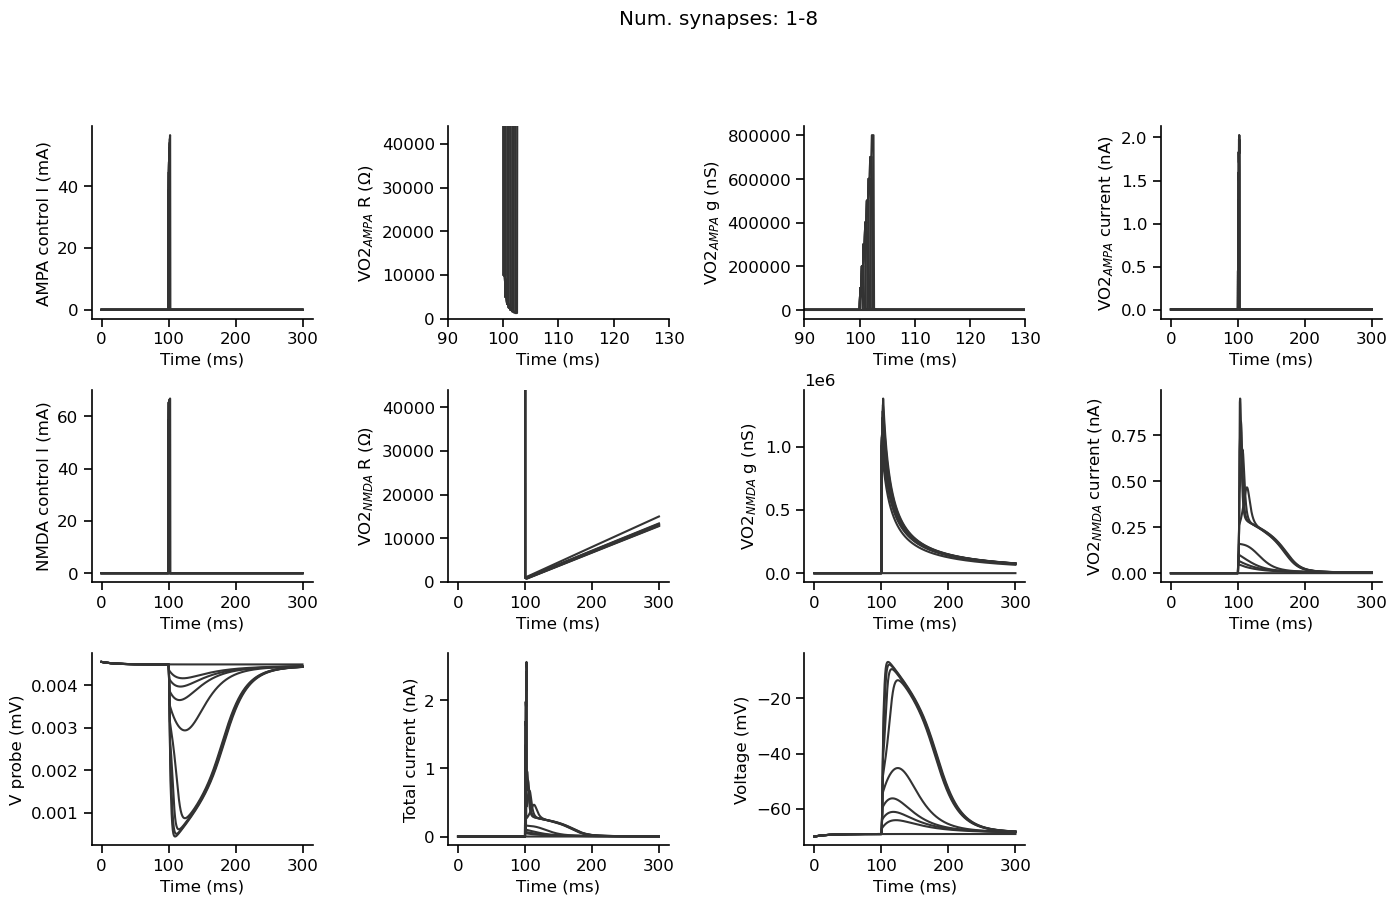

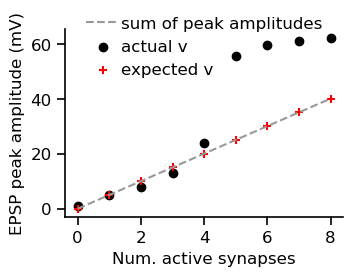

In [256]:
# Plot simulation results 

fig,ax = plt.subplots(3,4,figsize=(14,9))
titles = {'V': 'Voltage (mV)', 'I_total': 'Total current (nA)', 'V_probe': 'V probe (mV)', 
          'controlI_ampa': 'AMPA control I (mA)', 'controlI_nmda': 'NMDA control I (mA)',
          'I_ampa': 'VO2$_{AMPA}$ current (nA)',  'I_nmda': 'VO2$_{NMDA}$ current (nA)', 
          'R_ampa': 'VO2$_{AMPA}$ R (Ω)',         'R_nmda': 'VO2$_{NMDA}$ R (Ω)',
          'g_ampa': 'VO2$_{AMPA}$ g (nS)',        'g_nmda': 'VO2$_{NMDA}$ g (nS)'}

line_color = [0.2,0.2,0.2]

col=0
ax[0,col].plot(time, simulation_results['controlI_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['controlI_ampa'])

ax[1,col].plot(time, simulation_results['controlI_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['controlI_nmda'])
col+=1

ax[0,col].plot(time, simulation_results['R_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['R_ampa'])
ax[0,col].set_ylim(bottom=0, top=4.4e4)
ax[0,col].set_xlim([90,130])

ax[1,col].plot(time, simulation_results['R_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['R_nmda'])
ax[1,col].set_ylim(bottom=0, top=4.4e4)
col+=1

ax[0,col].plot(time, simulation_results['g_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['g_ampa'])
ax[0,col].set_xlim([90,130])

ax[1,col].plot(time, simulation_results['g_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['g_nmda'])
col+=1

ax[0,col].plot(time, simulation_results['I_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['I_ampa'])

ax[1,col].plot(time, simulation_results['I_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['I_nmda'])
col+=1


plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')


col=0
ax[2,col].plot(time, simulation_results['V_probe'], c=line_color)
ax[2,col].set_xlabel('Time (ms)')
ax[2,col].set_ylabel(titles['V_probe'])
col+=1

ax[2,col].plot(time, simulation_results['I_total'], c=line_color)
ax[2,col].set_xlabel('Time (ms)')
ax[2,col].set_ylabel(titles['I_total'])
col+=1

ax[2,col].plot(time, simulation_results['V']-70, c=line_color)
ax[2,col].set_xlabel('Time (ms)')
ax[2,col].set_ylabel(titles['V'])
baselines = simulation_results['single_EPSPs'][1000,:]
summed_EPSP_trace = np.sum(simulation_results['single_EPSPs']-baselines,axis=1) + baselines[1]
# ax[2,col].plot(time,summed_EPSP_trace-70,'--',linewidth=2.5,alpha=0.8,color='r', label='expected voltage')
# ax[2,col].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

ax[2,3].axis('off')

# measure_point = 1200
# singleEPSP_amplitudes = simulation_results['single_EPSPs'][measure_point,:] - baselines
# linear_sum = np.cumsum(singleEPSP_amplitudes)
# expected_amplitudes = np.cumsum(simulation_results['single_EPSPs']-baselines,axis=1)[measure_point,:]
# multiEPSP_amplitudes = simulation_results['V'][measure_point,:] - baselines
# num_EPSPs = len(multiEPSP_amplitudes)

singleEPSP_amplitudes = np.max(simulation_results['single_EPSPs'],axis=0) - baselines
linear_sum = np.cumsum(singleEPSP_amplitudes)
expected_amplitudes = np.max(np.cumsum(simulation_results['single_EPSPs']-baselines,axis=1),axis=0)
multiEPSP_amplitudes = np.max(simulation_results['V'],axis=0) - baselines
num_EPSPs = len(multiEPSP_amplitudes)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6], label='sum of peak amplitudes')
ax.scatter(np.arange(num_EPSPs), multiEPSP_amplitudes, color='k', label='actual v')
ax.scatter(np.arange(num_EPSPs), expected_amplitudes, marker='+',color='r',label='expected v')
ax.set_ylabel('EPSP peak amplitude (mV)')
ax.set_xlabel('Num. active synapses')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)

plt.show()

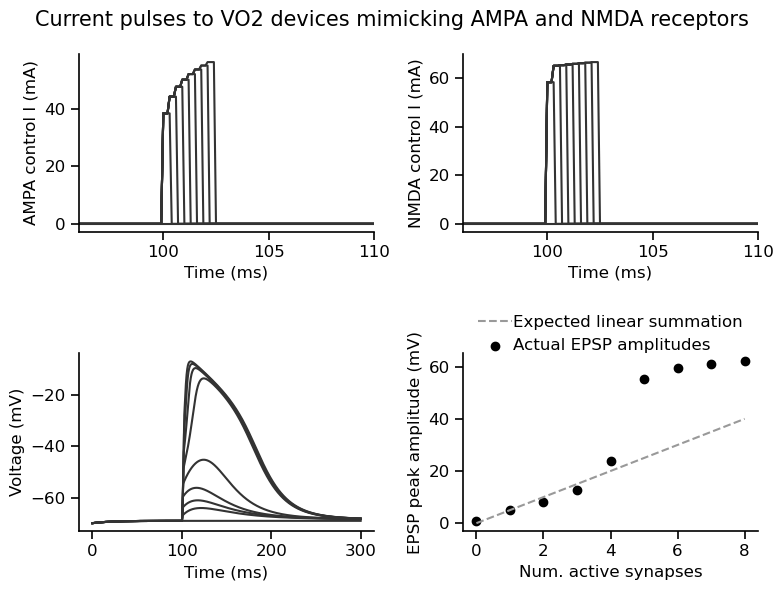

In [259]:
# Simplified figure 

fig,ax = plt.subplots(2,2,figsize=(8,6))

plot_nr = (0,0)
ax[plot_nr].plot(time, simulation_results['controlI_ampa'], c=line_color)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['controlI_ampa'])
ax[plot_nr].set_xlim([96,110])

plot_nr = (0,1)
ax[plot_nr].plot(time, simulation_results['controlI_nmda'], c=line_color)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['controlI_nmda'])
ax[plot_nr].set_xlim([96,110])

plot_nr = (1,0)
ax[plot_nr].plot(time, simulation_results['V']-70, c=line_color)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])
baselines = simulation_results['single_EPSPs'][1000,:]
summed_EPSP_trace = np.sum(simulation_results['single_EPSPs']-baselines,axis=1) + baselines[1]
# ax[plot_nr].plot(time,summed_EPSP_trace-70,'--',linewidth=2.5,alpha=0.8,color='r', label='expected voltage')
# ax[plot_nr].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plot_nr = (1,1)
ax[plot_nr].plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6], label='Expected linear summation')
ax[plot_nr].scatter(np.arange(num_EPSPs), multiEPSP_amplitudes, color='k', label='Actual EPSP amplitudes')
ax[plot_nr].set_ylabel('EPSP peak amplitude (mV)')
ax[plot_nr].set_xlabel('Num. active synapses')
ax[plot_nr].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))

fig.suptitle('Current pulses to VO2 devices mimicking AMPA and NMDA receptors',fontsize=15)


plt.tight_layout()
plt.show()

fig.savefig('figures/NMDA_supralinear_summation.png', dpi=300)
fig.savefig('figures/NMDA_supralinear_summation.svg', dpi=300)

# <font color='blue'> 3. One-shot learning with neuromorphic hardware </font>


### Biological simulation

In [555]:
# BTSP weight update function 

def get_scaled_rectified_sigmoid(th=0.01, peak=0.02, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    sigmoid_func = lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (np.clip(xi, x[0], x[-1]) - th))) - start_val) + ylim[0]
    return sigmoid_func

input_dim = 50
t_res = 0.01
tau_ET = 2.5
tau_IS = 1.5
sig_learning_rate = 1.7
sig_dep_ratio = 0.12
sig_max_weight = 5.
sig_dep_th = 0.01
sig_dep_width = 0.045
sig_pot_th = 0.5
sig_pot_width = 0.5
sig_dW_params = [sig_learning_rate, sig_dep_ratio, sig_max_weight]
sig_dep = get_scaled_rectified_sigmoid(sig_dep_th, sig_dep_th + sig_dep_width)
sig_pot = get_scaled_rectified_sigmoid(sig_pot_th, sig_pot_th + sig_pot_width)

def btsp(ET, IS, W, Wmax):
    k_pot = sig_learning_rate
    k_dep = sig_learning_rate * sig_dep_ratio
    dW = (Wmax - W) * k_pot * sig_pot(ET*IS) - W * k_dep * sig_dep(ET*IS)
    return dW

# learning_rate = 1.
# input_peak_rate = 2.0
# max_weight_scale = 5.

# pre = np.linspace(0., input_peak_rate, 1000)
# w0 = np.linspace(0., max_weight_scale, 1000)
# pre_mesh, w0_mesh = np.meshgrid(pre, w0)

# plt.figure(figsize=[6,4])
# plt.pcolormesh(pre_mesh, w0_mesh,
#                btsp(pre_mesh, IS=1., W=w0_mesh, Wmax=max_weight_scale),
#                cmap='RdBu_r', shading='nearest',
#                vmin=-max_weight_scale * learning_rate, vmax=max_weight_scale * learning_rate)
# plt.xlabel('Elegibility Trace (pre)')
# plt.ylabel('Initial weight')
# cbar = plt.colorbar()
# cbar.set_label('Delta weight', rotation=-90., labelpad=10)
# plt.title('BTSP Fixed Points')
# plt.show()


sig_dep_ratio = 0.12 *2
sig_learning_rate = 1.7

sig_dep_th = 0.01
sig_dep_width = 0.015
sig_pot_th = 0.12
sig_pot_width = 0.1
sig_dep = get_scaled_rectified_sigmoid(sig_dep_th, sig_dep_th + sig_dep_width)
sig_pot = get_scaled_rectified_sigmoid(sig_pot_th, sig_pot_th + sig_pot_width)

# x = np.linspace(0,1,1000)
# plt.plot(x,sig_dep(x),c='b')
# plt.plot(x,sig_pot(x),c='r')
# plt.plot(x,sig_pot(x)-sig_dep(x)*sig_dep_ratio,c='k')
# plt.plot([0,1],[0,0],'k--',alpha=0.5)
# plt.show()

In [556]:
# Run simulation of place cell with uniform equal weights

# Simulation runtime parameters
dt = 1.  # time step (ms)
T = 10000   # simulation time (ms)
time = np.arange(0., T, dt)

# def btsp(ET_IS, W, Wmax):
#     k_pot = sig_learning_rate
#     k_dep = sig_learning_rate * sig_dep_ratio
#     dW = (Wmax - W) * k_pot * sig_pot(ET_IS) - W * k_dep * sig_dep(ET_IS)
#     return dW

def btsp(ET, IS, W, Wmax):
    k_pot = sig_learning_rate
    k_dep = sig_learning_rate * sig_dep_ratio
    dW = (Wmax - W) * k_pot * sig_pot(ET*IS) - W * k_dep * sig_dep(ET*IS)
    return dW

def run_simulation(num_synapses, w_init, plateau_time):

    ET_tau = 2500 # (ms)
    IS_tau = 1500 # (ms)
    duration = 300
    Wmax = 5.

    plateau_time = np.round(plateau_time /dt) # (ms)
    first_stim_time = 100 # (ms)
    last_stim_time = T - first_stim_time
    stim_timesteps = np.linspace(first_stim_time, last_stim_time, num_synapses) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    
    # Initialize simulation variables
    simulation_results = {}
    weights = np.ones([len(time),num_synapses]) *w_init

    ET = np.zeros([len(time),num_synapses]) #presynaptic elegibility traces
    IS = np.zeros(len(time)) # postsynaptic instructive signal (plateau)
    
    for t in range(len(time)): 
        if t in stim_timesteps:
            active_synapse_ids = np.where(stim_timesteps==t)[0]
            ET[t,active_synapse_ids] += 0.3
            
        if t >= plateau_time and t < plateau_time + duration:
#             IS[t] = 1
            dISdt = (1 - IS[t])/ (IS_tau*0.03)
            IS[t] = IS[t] + dISdt*dt
            
        if t<len(time)-1: #don't update at the last timestep
            dETdt = -ET[t] / ET_tau
            ET[t+1] = ET[t] + dETdt*dt
            
            dISdt = -IS[t] / IS_tau
            IS[t+1] = IS[t] + dISdt*dt

            dW = btsp(ET[t], IS[t], weights[t], Wmax)
            weights[t+1] = weights[t] + dW*dt/1000

#     ET_IS = np.dot(IS,ET)  
#     ET_IS = ET_IS / np.max(ET_IS)
#     dW = btsp(ET_IS, weights, Wmax)
#     final_weights = weights + lr*dW
    
    simulation_results['el_traces'] = ET
    simulation_results['stim_times'] = stim_timesteps
    simulation_results['IS'] = IS
    simulation_results['W'] = weights
#     simulation_results['W'] = (weights, final_weights)

    return simulation_results
    
num_synapses = 30
init_weights = np.ones(num_synapses) * 1

weights = init_weights

simulation_results = run_simulation(num_synapses, weights, plateau_time=3000)
weights = simulation_results['W'][-1]

simulation_results2 = run_simulation(num_synapses, weights, plateau_time=7000)
weights = simulation_results2['W'][-1]

# for i in range(3):
#     simulation_results = run_simulation(num_synapses, weights, plateau_time=3000)
#     weights = simulation_results['W'][-1]
    
# for i in range(3):
#     simulation_results2 = run_simulation(num_synapses, weights, plateau_time=7000)
#     weights = simulation_results2['W'][-1]

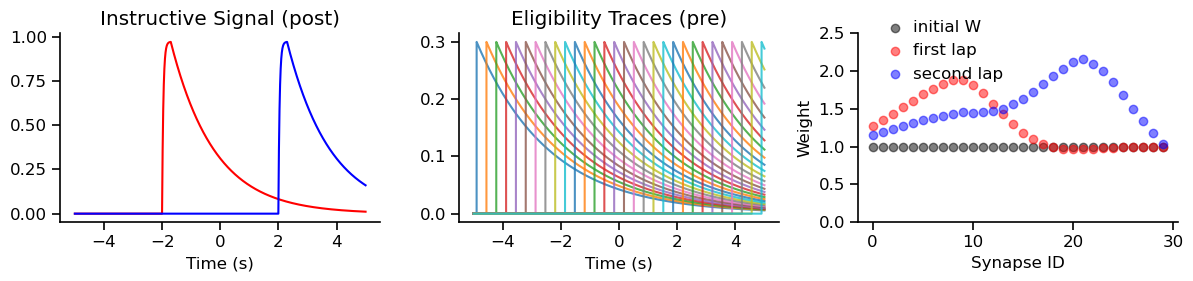

In [557]:
# Plot simulation results 

line_color = [0.2,0.2,0.2]
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 'el_traces':'Eligibility Traces (pre)',
         'IS': 'Instructive Signal (post)', 'W': 'Weight'}

time = np.arange(-T/2, T/2, dt)/1000

fig,ax = plt.subplots(1,3,figsize=(12,3))
plot_nr = (0)
ax[plot_nr].plot(time, simulation_results['IS'], c='r')
ax[plot_nr].plot(time, simulation_results2['IS'], c='b')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_title(titles['IS'])

plot_nr = (1)
ax[plot_nr].plot(time, simulation_results['el_traces'], alpha=0.8)
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_title(titles['el_traces'])

plot_nr = (2)
ax[plot_nr].scatter(np.arange(num_synapses), init_weights, c='k', alpha=0.5, label='initial W')
ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][-1,:], c='r', alpha=0.5, label='first lap')
ax[plot_nr].scatter(np.arange(num_synapses), simulation_results2['W'][-1,:], c='b', alpha=0.5, label='second lap')

# ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][0], c='k', alpha=0.5, label='initial W')
# ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][1], c='r', alpha=0.5, label='first lap')
# ax[plot_nr].scatter(np.arange(num_synapses), simulation_results2['W'][1], c='b', alpha=0.5, label='second lap')
ax[plot_nr].set_xlabel('Synapse ID')
ax[plot_nr].set_ylabel(titles['W'])
ax[plot_nr].set_ylim([0,2.5])
ax[plot_nr].legend(loc='upper right', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
# plt.subplots_adjust(top=0.8)
plt.show()

### Neuromorphic simulation

In [558]:
# Run simulation of place cell with uniform equal weights 

# Simulation runtime parameters
dt = 1.  # time step (ms)
T = 10000   # simulation time (ms)
time = np.arange(0., T, dt)

def btsp(ET, IS, W, Wmax):
    k_pot = sig_learning_rate
    k_dep = sig_learning_rate * sig_dep_ratio
    dW = (Wmax - W) * k_pot * sig_pot(ET*IS) - W * k_dep * sig_dep(ET*IS)
    return dW

def run_simulation(num_synapses, w_init, plateau_time, stim_times=None):

    ET_tau = 2500 # (ms)
    IS_tau = 1500 # (ms)
    duration = 300.
    controlV_dur = 10.
    Wmax = 5.

    plateau_time = np.round(plateau_time /dt) # (ms)
    
    if stim_times is None:
        first_stim_time = 100 # (ms)
        last_stim_time = T - first_stim_time
        stim_timesteps = np.linspace(first_stim_time, last_stim_time, num_synapses) / dt
    else:
        stim_timesteps = stim_times
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    stim_timesteps_extended = np.repeat(stim_timesteps,controlV_dur) + np.tile(np.arange(controlV_dur),len(stim_timesteps))
    
    # Initialize simulation variables
    simulation_results = {}
    weights = np.ones([len(time),num_synapses]) *w_init
    ET = np.zeros([len(time),num_synapses]) #presynaptic elegibility traces
    IS = np.zeros(len(time)) # postsynaptic instructive signal (plateau)

    synapse_list = []
    for i in range(num_synapses):
        synapse_list.append(Volatile_Resistor(dt, timescale=75))
    VO2_IS = Volatile_Resistor(dt, timescale=68)
    
    for t in range(len(time)): 
        if t in stim_timesteps_extended:
            # Increment synaptic el traces
            active_synapse_ids = np.where(stim_timesteps==t)[0]
            for i in active_synapse_ids:
                ET_targetR = synapse_list[i].R - 9e5
                synapse_list[i].controlI = synapse_list[i].inv_transfer_func(ET_targetR)
        else:
            for synapse in synapse_list:
                synapse.controlI = 0

        if t >= plateau_time and t < plateau_time + duration:
            # Increment IS trace
            dISdt = (2000 - VO2_IS.R)/ (IS_tau*0.03)
            IS_targetR = VO2_IS.R + dISdt*dt
            VO2_IS.controlI = VO2_IS.inv_transfer_func(IS_targetR)    
        else:
            VO2_IS.controlI = 0
            
        IS[t] = np.abs(1e6-VO2_IS.R)/1e6
        for i,synapse in enumerate(synapse_list):
            ET[t,i] = np.abs(1e6-synapse.R)/3e6
            
        if t<len(time)-1: #don't update at the last timestep
            dW = btsp(ET[t], IS[t], weights[t], Wmax)
            weights[t+1] = weights[t] + dW*dt/1000
            
        VO2_IS.time_step()
        for synapse in synapse_list:
            synapse.time_step()
            
    simulation_results['stim_times'] = stim_timesteps
    simulation_results['ET_R'] = np.array([synapse.R_history for synapse in synapse_list]).T
    simulation_results['IS_R'] = VO2_IS.R_history
    simulation_results['ET'] = ET
    simulation_results['IS'] = IS
    simulation_results['W'] = weights
    return simulation_results
    
num_synapses = 30
init_weights = np.ones(num_synapses) * 1

weights = init_weights

simulation_results = run_simulation(num_synapses, weights, plateau_time=3000)
weights = simulation_results['W'][-1]

simulation_results2 = run_simulation(num_synapses, weights, plateau_time=7000)
weights = simulation_results2['W'][-1]

# for i in range(3):
#     simulation_results = run_simulation(num_synapses, weights, plateau_time=3000)
#     weights = simulation_results['W'][-1]
    
# for i in range(3):
#     simulation_results2 = run_simulation(num_synapses, weights, plateau_time=7000)
#     weights = simulation_results2['W'][-1]

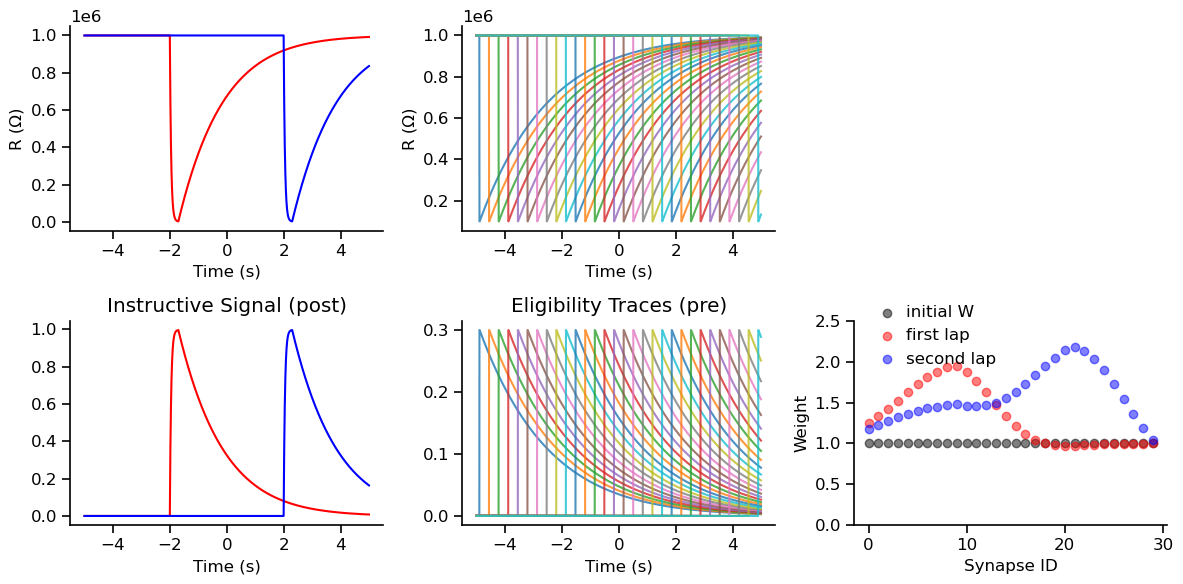

In [559]:
# Plot simulation results 

line_color = [0.2,0.2,0.2]
titles = {'ET':'Eligibility Traces (pre)', 'ET_R':'',
          'IS':'Instructive Signal (post)', 'IS_R':'', 'W':'Weight'}

time = np.arange(-T/2, T/2, dt)/1000

fig,ax = plt.subplots(2,3,figsize=(12,6))
plot_nr = (0,0)
ax[plot_nr].plot(time, simulation_results['IS_R'], c='r')
ax[plot_nr].plot(time, simulation_results2['IS_R'], c='b')
ax[plot_nr].set_ylabel('R (Ω)')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_title(titles['IS_R'])

plot_nr = (1,0)
ax[plot_nr].plot(time, simulation_results['IS'], c='r')
ax[plot_nr].plot(time, simulation_results2['IS'], c='b')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_title(titles['IS'])

plot_nr = (0,1)
ax[plot_nr].plot(time, simulation_results['ET_R'], alpha=0.8)
ax[plot_nr].set_ylabel('R (Ω)')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_title(titles['ET_R'])

plot_nr = (1,1)
ax[plot_nr].plot(time, simulation_results['ET'], alpha=0.8)
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_title(titles['ET'])

plot_nr = (1,2)
ax[plot_nr].scatter(np.arange(num_synapses), init_weights, c='k', alpha=0.5, label='initial W')
ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][-1,:], c='r', alpha=0.5, label='first lap')
ax[plot_nr].scatter(np.arange(num_synapses), simulation_results2['W'][-1,:], c='b', alpha=0.5, label='second lap')

# ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][0], c='k', alpha=0.5, label='initial W')
# ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][1], c='r', alpha=0.5, label='first lap')
# ax[plot_nr].scatter(np.arange(num_synapses), simulation_results2['W'][1], c='b', alpha=0.5, label='second lap')
ax[plot_nr].set_xlabel('Synapse ID')
ax[plot_nr].set_ylabel(titles['W'])
ax[plot_nr].set_ylim([0,2.5])
ax[plot_nr].legend(loc='upper right', bbox_to_anchor=(0.5, 1.15))

ax[0,2].axis('off')

plt.tight_layout()
# plt.subplots_adjust(top=0.8)
plt.show()

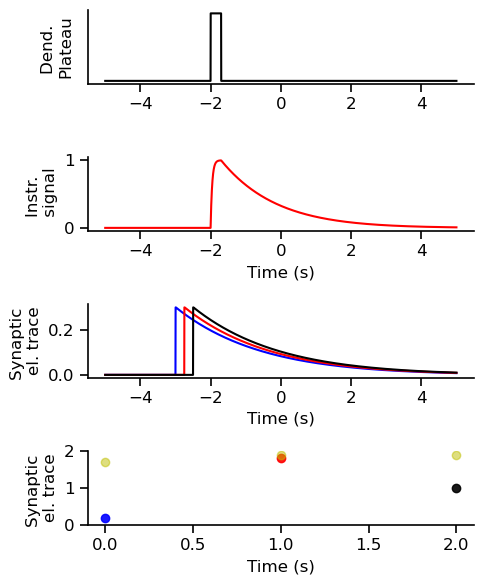

In [560]:
# Simple simulation (cf. BTSP eLife paper: Fig5 & Fig6-S3)

num_synapses = 3
# init_weights = np.ones(num_synapses) 
init_weights = [0.2,1.8,1.]
stim_times = np.linspace(2000,2500,num_synapses)

weights = init_weights
simulation_results = run_simulation(num_synapses, weights, plateau_time=3000, stim_times=stim_times)
weights = simulation_results['W'][-1]


fig, ax = plt.subplots(4,1,figsize=(5,6))
time = np.arange(-T/2, T/2, dt)/1000

plot_nr = 0
dend_plateau = np.zeros(len(time))
dend_plateau[3000:3300] = 1
ax[plot_nr].plot(time, dend_plateau, c='k')
ax[plot_nr].set_yticks([])
ax[plot_nr].set_ylabel('Dend. \nPlateau')

plot_nr = 1
ax[plot_nr].plot(time, simulation_results['IS'],c='r')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_ylabel('Instr. \n signal')

plot_nr = 2
ax[plot_nr].plot(time, simulation_results['ET'][:,0],c='b')
ax[plot_nr].plot(time, simulation_results['ET'][:,1],c='r')
ax[plot_nr].plot(time, simulation_results['ET'][:,2],c='k')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_ylabel('Synaptic \nel. trace')

plot_nr = 3
ax[plot_nr].scatter([0], init_weights[0], c='b', alpha=0.9, label='initial W')
ax[plot_nr].scatter([1], init_weights[1], c='r', alpha=0.9, label='initial W')
ax[plot_nr].scatter([2], init_weights[2], c='k', alpha=0.9, label='initial W')
ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][-1,:], c='y', alpha=0.5, label='first lap')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_ylabel('Synaptic \nel. trace')
ax[plot_nr].set_ylim([0,2])

plt.tight_layout()
plt.show()